# 🎯 Cluster-Stratified Model Training - CROHN

**Objetivo:** Entrenar modelos específicos por cluster de fenotipo para CROHN y comparar con modelo global

**Hipótesis:** Los modelos estratificados por cluster (fenotipo de paciente) mejorarán las predicciones

**Plan:**
1. Cargar datos: data/processed/crohn/ml_dataset.csv + user_clusters.csv
2. Entrenar 3 modelos RF (uno por cluster) con SMOTE Moderado
3. Comparar métricas: Global vs Cluster-Specific
4. Guardar: models/crohn/ - 3 modelos RF + KMeans scaler para inferencia

**Autor:** Claude Assistant + Asier Ortiz García  
**Fecha:** Noviembre 2025

## 📦 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    f1_score, precision_score, recall_score, accuracy_score
)
from imblearn.over_sampling import SMOTE
from collections import Counter

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
%matplotlib inline

# Crear directorios para Crohn
Path('../models/crohn').mkdir(parents=True, exist_ok=True)
Path('../docs/figures').mkdir(parents=True, exist_ok=True)
Path('../reports').mkdir(parents=True, exist_ok=True)

print("=" * 80)
print("CLUSTER-STRATIFIED MODEL TRAINING - CROHN")
print("Entrenamiento de modelos específicos por fenotipo de paciente")
print("=" * 80)

CLUSTER-STRATIFIED MODEL TRAINING - CROHN
Entrenamiento de modelos específicos por fenotipo de paciente


## 1️⃣ Cargar Datos

In [2]:
# Cargar dataset ML de Crohn - Enhanced (con features derivadas del notebook 03)
enhanced_path = '../data/processed/crohn/ml_dataset_enhanced.csv'
base_path = '../data/processed/crohn/ml_dataset.csv'

if Path(enhanced_path).exists():
    print("📊 Usando dataset con features derivadas (enhanced)...")
    df_ml = pd.read_csv(enhanced_path)
    using_enhanced = True
else:
    print("⚠️  Dataset enhanced no encontrado, usando dataset base...")
    print("   💡 Ejecuta notebook 03_advanced_feature_engineering.ipynb primero para mejores resultados")
    df_ml = pd.read_csv(base_path)
    using_enhanced = False

print(f"✓ ML Dataset (Crohn): {len(df_ml):,} registros")

# Cargar clusters de usuarios de Crohn (del notebook 01 V2)
df_clusters = pd.read_csv('../data/processed/crohn/user_clusters.csv', index_col=0)
print(f"✓ User Clusters (Crohn): {len(df_clusters):,} usuarios con cluster asignado")

# Cargar metadata
base_metadata_path = '../data/processed/crohn/ml_dataset_metadata.json'
derived_metadata_path = '../data/processed/derived_features_metadata.json'

with open(base_metadata_path, 'r') as f:
    base_metadata = json.load(f)

# Features base
base_features = base_metadata['features']
target_col = base_metadata['target']

# Si usamos enhanced, cargar features derivadas también
if using_enhanced and Path(derived_metadata_path).exists():
    with open(derived_metadata_path, 'r') as f:
        derived_metadata = json.load(f)
    
    derived_features = derived_metadata['derived_features']
    
    # Combinar features (base + derivadas, excluyendo duplicados)
    all_features = list(dict.fromkeys(base_features + derived_features))
    
    # Filtrar solo features que existan en el DataFrame
    feature_cols = [f for f in all_features if f in df_ml.columns and f != target_col]
    
    print(f"\n📋 Features Base: {len(base_features)}")
    print(f"📋 Features Derivadas: {len(derived_features)}")
    print(f"📋 Features Totales: {len(feature_cols)}")
else:
    feature_cols = base_features
    print(f"\n📋 Features: {len(feature_cols)}")

print(f"📋 Target: {target_col}")
print(f"\n✅ Usando {len(feature_cols)} features para entrenamiento")

if using_enhanced:
    print(f"\n🎯 Features derivadas incluidas:")
    derived_in_use = [f for f in derived_features if f in feature_cols]
    for cat, feats in derived_metadata.get('categories', {}).items():
        cat_feats = [f for f in feats if f in derived_in_use]
        if cat_feats:
            print(f"  • {cat}: {len(cat_feats)} features")
            for f in cat_feats[:3]:  # Mostrar primeras 3
                print(f"    - {f}")
            if len(cat_feats) > 3:
                print(f"    ... y {len(cat_feats) - 3} más")

📊 Usando dataset con features derivadas (enhanced)...
✓ ML Dataset (Crohn): 7,618 registros
✓ User Clusters (Crohn): 641 usuarios con cluster asignado

📋 Features Base: 13
📋 Features Derivadas: 21
📋 Features Totales: 34
📋 Target: risk_level

✅ Usando 34 features para entrenamiento

🎯 Features derivadas incluidas:
  • symptom_aggregations: 5 features
    - total_symptom_score
    - gi_score
    - systemic_score
    ... y 2 más
  • temporal_features: 6 features
    - pain_trend_7d
    - diarrhea_trend_7d
    - fatigue_trend_7d
    ... y 3 más
  • history_features: 4 features
    - flare_frequency
    - recency_score
    - disease_burden
    ... y 1 más
  • interaction_features: 5 features
    - pain_diarrhea_combo
    - blood_and_pain
    - vulnerable_state
    ... y 2 más


## 2️⃣ Merge Clusters con ML Dataset

In [3]:
# Merge datasets por user_id
df = df_ml.merge(df_clusters[['cluster']], left_on='user_id', right_index=True, how='inner')

print(f"Dataset combinado: {len(df):,} registros")
print(f"\nDistribución de clusters:")
cluster_dist = df['cluster'].value_counts().sort_index()
for cluster_id, count in cluster_dist.items():
    pct = count / len(df) * 100
    print(f"  Cluster {cluster_id}: {count:6,} ({pct:5.1f}%)")

print(f"\nDistribución de risk_level:")
risk_dist = df['risk_level'].value_counts()
for risk, count in risk_dist.items():
    pct = count / len(df) * 100
    print(f"  {risk.upper():8} {count:6,} ({pct:5.1f}%)")

Dataset combinado: 7,027 registros

Distribución de clusters:
  Cluster 0:    292 (  4.2%)
  Cluster 1:  6,612 ( 94.1%)
  Cluster 2:    123 (  1.8%)

Distribución de risk_level:
  LOW       5,168 ( 73.5%)
  MEDIUM    1,730 ( 24.6%)
  HIGH        129 (  1.8%)


## 3️⃣ Análisis: Distribución de Risk Level por Cluster


📊 Distribución de Risk Level por Cluster (%):

risk_level  high   low  medium
cluster                       
0           11.3  48.6    40.1
1            1.4  74.9    23.6
2            0.8  58.5    40.7


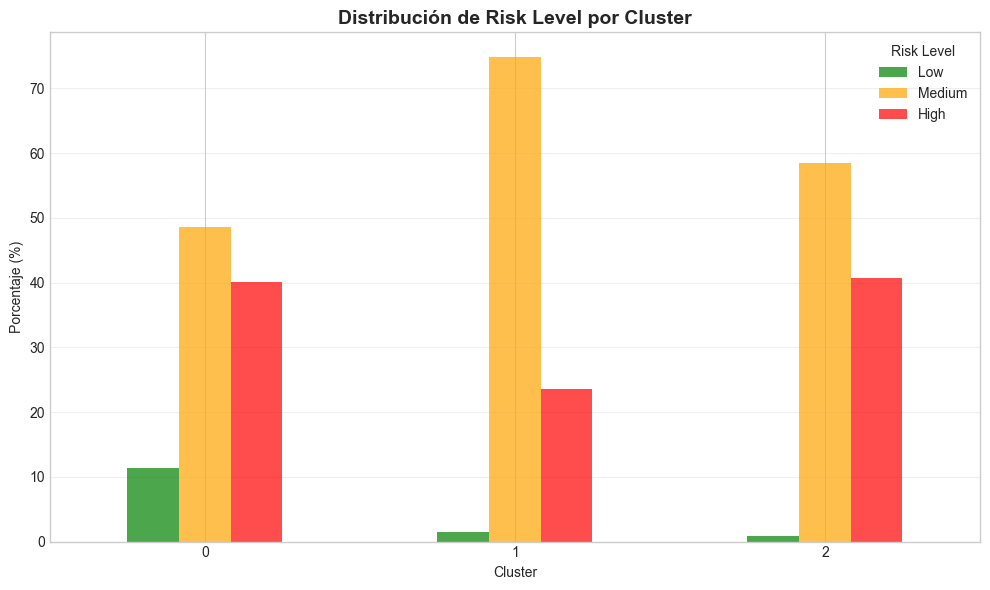


💡 Observación: Si los clusters muestran diferentes distribuciones de risk,
   los modelos estratificados podrían aprender patrones específicos.


In [4]:
# Tabla cruzada
cross_tab = pd.crosstab(df['cluster'], df['risk_level'], normalize='index') * 100
print("\n📊 Distribución de Risk Level por Cluster (%):\n")
print(cross_tab.round(1))

# Visualizar
fig, ax = plt.subplots(figsize=(10, 6))
cross_tab.plot(kind='bar', ax=ax, color=['green', 'orange', 'red'], alpha=0.7)
ax.set_title('Distribución de Risk Level por Cluster', fontsize=14, fontweight='bold')
ax.set_xlabel('Cluster')
ax.set_ylabel('Porcentaje (%)')
ax.legend(title='Risk Level', labels=['Low', 'Medium', 'High'])
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../docs/figures/risk_by_cluster.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 Observación: Si los clusters muestran diferentes distribuciones de risk,")
print("   los modelos estratificados podrían aprender patrones específicos.")

## 4️⃣ Preparar Datos

In [5]:
# Encode gender
gender_map = {'M': 1, 'F': 2, 'O': 0}
df['gender'] = df['gender'].map(gender_map)

# Separar features y target
X = df[feature_cols].copy()
y = df[target_col].copy()
clusters = df['cluster'].copy()

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"Clusters: {clusters.shape}")

# Verificar valores faltantes
missing = X.isnull().sum().sum()
if missing > 0:
    print(f"\n⚠️  {missing} valores faltantes - imputando con mediana...")
    X.fillna(X.median(), inplace=True)
else:
    print(f"\n✓ Sin valores faltantes")

Features (X): (7027, 34)
Target (y): (7027,)
Clusters: (7027,)

✓ Sin valores faltantes


## 5️⃣ Train/Test Split (Estratificado por risk_level Y cluster)

In [6]:
# Crear stratification key (risk_level + cluster)
stratify_key = y.astype(str) + '_' + clusters.astype(str)

# Verificar si hay suficientes muestras para estratificación
from collections import Counter
stratify_counts = Counter(stratify_key)
min_count = min(stratify_counts.values())

print(f"Muestras mínimas por combinación risk_level+cluster: {min_count}")

if min_count < 2:
    print("⚠️  Algunas combinaciones tienen <2 muestras. Estratificando solo por risk_level...")
    stratify_by = y
elif min_count < 5:
    print("⚠️  Pocas muestras en algunas combinaciones. Estratificando solo por risk_level...")
    stratify_by = y
else:
    print("✓ Suficientes muestras. Estratificando por risk_level + cluster")
    stratify_by = stratify_key

X_train, X_test, y_train, y_test, clusters_train, clusters_test = train_test_split(
    X, y, clusters,
    test_size=0.2,
    stratify=stratify_by,
    random_state=42
)

print(f"\nTrain set: {len(X_train):,} samples")
print(f"Test set:  {len(X_test):,} samples")

print(f"\nDistribución de clusters en Train:")
for cluster_id in sorted(clusters_train.unique()):
    count = (clusters_train == cluster_id).sum()
    pct = count / len(clusters_train) * 100
    print(f"  Cluster {cluster_id}: {count:5,} ({pct:5.1f}%)")

print(f"\nDistribución de clusters en Test:")
for cluster_id in sorted(clusters_test.unique()):
    count = (clusters_test == cluster_id).sum()
    pct = count / len(clusters_test) * 100
    print(f"  Cluster {cluster_id}: {count:5,} ({pct:5.1f}%)")

Muestras mínimas por combinación risk_level+cluster: 1
⚠️  Algunas combinaciones tienen <2 muestras. Estratificando solo por risk_level...

Train set: 5,621 samples
Test set:  1,406 samples

Distribución de clusters en Train:
  Cluster 0:   244 (  4.3%)
  Cluster 1: 5,277 ( 93.9%)
  Cluster 2:   100 (  1.8%)

Distribución de clusters en Test:
  Cluster 0:    48 (  3.4%)
  Cluster 1: 1,335 ( 95.0%)
  Cluster 2:    23 (  1.6%)


## 6️⃣ Entrenar Modelo Global (Baseline)

Primero entrenamos el modelo global como baseline para comparación.

In [7]:
print("\n" + "="*80)
print("🌲 MODELO GLOBAL (Baseline)")
print("="*80 + "\n")

# SMOTE Moderado (igual que notebook 03)
train_counts = Counter(y_train)
total_train = len(y_train)
target_high = int(total_train * 0.15)
target_medium = int(total_train * 0.35)

smote_mod = SMOTE(
    sampling_strategy={'high': target_high, 'medium': target_medium},
    random_state=42
)

print("Aplicando SMOTE Moderado...")
X_train_smote, y_train_smote = smote_mod.fit_resample(X_train, y_train)

smote_counts = Counter(y_train_smote)
print(f"Distribución después de SMOTE:")
for cls in ['low', 'medium', 'high']:
    count = smote_counts[cls]
    pct = count / len(y_train_smote) * 100
    print(f"  {cls.upper():8} {count:5,} ({pct:5.1f}%)")

# Entrenar modelo global
model_global = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("\nEntrenando modelo global...")
model_global.fit(X_train_smote, y_train_smote)
print("✓ Entrenamiento completado")

# Evaluar
y_pred_global = model_global.predict(X_test)

print("\n📊 Métricas del Modelo Global:\n")
print(classification_report(y_test, y_pred_global, 
                          target_names=['low', 'medium', 'high'],
                          digits=3))

# Guardar métricas globales para comparación
global_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_global),
    'f1_macro': f1_score(y_test, y_pred_global, average='macro'),
    'f1_low': f1_score(y_test, y_pred_global, labels=['low'], average='macro'),
    'f1_medium': f1_score(y_test, y_pred_global, labels=['medium'], average='macro'),
    'f1_high': f1_score(y_test, y_pred_global, labels=['high'], average='macro'),
    'recall_high': recall_score(y_test, y_pred_global, labels=['high'], average='macro'),
    'precision_high': precision_score(y_test, y_pred_global, labels=['high'], average='macro')
}

print(f"\n📈 Métricas clave:")
print(f"  Accuracy:      {global_metrics['accuracy']:.3f}")
print(f"  F1 Macro:      {global_metrics['f1_macro']:.3f}")
print(f"  F1 High:       {global_metrics['f1_high']:.3f}")
print(f"  Recall High:   {global_metrics['recall_high']:.3f}")
# Guardar modelo global
global_model_path = '../models/crohn/rf_severity_classifier_global.pkl'
with open(global_model_path, 'wb') as f:
    pickle.dump(model_global, f)
print(f"\n💾 Modelo global guardado: {global_model_path}")



🌲 MODELO GLOBAL (Baseline)

Aplicando SMOTE Moderado...
Distribución después de SMOTE:
  LOW      4,134 ( 59.5%)
  MEDIUM   1,967 ( 28.3%)
  HIGH       843 ( 12.1%)

Entrenando modelo global...
✓ Entrenamiento completado

📊 Métricas del Modelo Global:

              precision    recall  f1-score   support

         low      0.929     1.000     0.963        26
      medium      1.000     0.991     0.996      1034
        high      0.975     0.994     0.984       346

    accuracy                          0.992      1406
   macro avg      0.968     0.995     0.981      1406
weighted avg      0.992     0.992     0.992      1406


📈 Métricas clave:
  Accuracy:      0.992
  F1 Macro:      0.981
  F1 High:       0.963
  Recall High:   1.000

💾 Modelo global guardado: ../models/crohn/rf_severity_classifier_global.pkl


## 7️⃣ Entrenar Modelos por Cluster

In [8]:
print("\n" + "="*80)
print("🎯 MODELOS ESTRATIFICADOS POR CLUSTER")
print("="*80 + "\n")

cluster_models = {}
cluster_metrics = {}
cluster_predictions = {}

for cluster_id in sorted(clusters_train.unique()):
    print(f"\n{'='*80}")
    print(f"🔬 CLUSTER {cluster_id}")
    print(f"{'='*80}\n")
    
    # Filtrar datos del cluster
    train_mask = clusters_train == cluster_id
    test_mask = clusters_test == cluster_id
    
    X_train_cluster = X_train[train_mask]
    y_train_cluster = y_train[train_mask]
    X_test_cluster = X_test[test_mask]
    
    # Saltar clusters con test set vacío o demasiado pequeños
    if len(X_test_cluster) == 0:
        print(f"⚠️  Test set vacío. Saltando Cluster {cluster_id}...")
        print(f"   Este cluster tiene muy pocas muestras para entrenar un modelo confiable.\n")
        continue
    
    if len(X_train_cluster) < 10:
        print(f"⚠️  Train set muy pequeño ({len(X_train_cluster)} muestras). Saltando Cluster {cluster_id}...")
        print(f"   Se requieren al menos 10 muestras para entrenar un modelo confiable.\n")
        continue
    y_test_cluster = y_test[test_mask]
    
    print(f"Train samples: {len(X_train_cluster):,}")
    print(f"Test samples:  {len(X_test_cluster):,}")
    
    # Distribución de clases
    print(f"\nDistribución de clases (train):")
    train_dist = Counter(y_train_cluster)
    for cls in ['low', 'medium', 'high']:
        count = train_dist.get(cls, 0)
        pct = count / len(y_train_cluster) * 100 if len(y_train_cluster) > 0 else 0
        print(f"  {cls.upper():8} {count:5,} ({pct:5.1f}%)")
    
    # SMOTE si hay suficientes muestras
    if len(X_train_cluster) >= 50 and len(train_dist) >= 2:
        try:
            # Ajustar targets de SMOTE según tamaño del cluster
            cluster_total = len(y_train_cluster)
            cluster_high = int(cluster_total * 0.15)
            cluster_medium = int(cluster_total * 0.35)
            
            # Solo aplicar SMOTE si hay al menos 2 muestras de cada clase minoritaria
            min_samples = min([v for k, v in train_dist.items() if k in ['medium', 'high']])
            
            if min_samples >= 2:
                smote_cluster = SMOTE(
                    sampling_strategy={
                        'high': max(cluster_high, train_dist.get('high', 0)),
                        'medium': max(cluster_medium, train_dist.get('medium', 0))
                    },
                    random_state=42
                )
                
                print("\nAplicando SMOTE...")
                X_train_cluster_smote, y_train_cluster_smote = smote_cluster.fit_resample(
                    X_train_cluster, y_train_cluster
                )
                
                smote_dist = Counter(y_train_cluster_smote)
                print(f"Distribución después de SMOTE:")
                for cls in ['low', 'medium', 'high']:
                    count = smote_dist.get(cls, 0)
                    pct = count / len(y_train_cluster_smote) * 100
                    print(f"  {cls.upper():8} {count:5,} ({pct:5.1f}%)")
            else:
                print("\n⚠️  Pocas muestras minoritarias, saltando SMOTE")
                X_train_cluster_smote = X_train_cluster
                y_train_cluster_smote = y_train_cluster
        except Exception as e:
            print(f"\n⚠️  Error en SMOTE: {e}")
            print("   Continuando sin SMOTE...")
            X_train_cluster_smote = X_train_cluster
            y_train_cluster_smote = y_train_cluster
    else:
        print("\n⚠️  Cluster pequeño, entrenando sin SMOTE")
        X_train_cluster_smote = X_train_cluster
        y_train_cluster_smote = y_train_cluster
    
    # Entrenar modelo del cluster
    model_cluster = RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=4,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    print("\nEntrenando modelo...")
    model_cluster.fit(X_train_cluster_smote, y_train_cluster_smote)
    print("✓ Entrenamiento completado")
    
    # Evaluar en test set del cluster
    y_pred_cluster = model_cluster.predict(X_test_cluster)
    
    # Detectar clases únicas presentes en test set
    unique_classes = sorted(y_test_cluster.unique())
    target_names_cluster = [cls for cls in ['low', 'medium', 'high'] if cls in unique_classes]
    
    print("\n📊 Métricas del Cluster:\n")
    if len(unique_classes) < 3:
        print(f"⚠️  Test set solo tiene {len(unique_classes)} clases: {unique_classes}")
    print(classification_report(y_test_cluster, y_pred_cluster,
                              target_names=target_names_cluster,
                              digits=3,
                              zero_division=0))
    
    # Guardar métricas
    cluster_metrics[cluster_id] = {
        'accuracy': accuracy_score(y_test_cluster, y_pred_cluster),
        'f1_macro': f1_score(y_test_cluster, y_pred_cluster, average='macro', zero_division=0),
        'f1_low': f1_score(y_test_cluster, y_pred_cluster, labels=['low'], average='macro', zero_division=0),
        'f1_medium': f1_score(y_test_cluster, y_pred_cluster, labels=['medium'], average='macro', zero_division=0),
        'f1_high': f1_score(y_test_cluster, y_pred_cluster, labels=['high'], average='macro', zero_division=0),
        'recall_high': recall_score(y_test_cluster, y_pred_cluster, labels=['high'], average='macro', zero_division=0),
        'precision_high': precision_score(y_test_cluster, y_pred_cluster, labels=['high'], average='macro', zero_division=0),
        'n_train': len(X_train_cluster),
        'n_test': len(X_test_cluster)
    }
    
    # Guardar modelo y predicciones
    cluster_models[cluster_id] = model_cluster
    cluster_predictions[cluster_id] = {
        'y_true': y_test_cluster,
        'y_pred': y_pred_cluster
    }
    
    print(f"\n✓ Cluster {cluster_id} completado")


🎯 MODELOS ESTRATIFICADOS POR CLUSTER


🔬 CLUSTER 0

Train samples: 244
Test samples:  48

Distribución de clases (train):
  LOW        120 ( 49.2%)
  MEDIUM      97 ( 39.8%)
  HIGH        27 ( 11.1%)

Aplicando SMOTE...
Distribución después de SMOTE:
  LOW        120 ( 47.4%)
  MEDIUM      97 ( 38.3%)
  HIGH        36 ( 14.2%)

Entrenando modelo...
✓ Entrenamiento completado

📊 Métricas del Cluster:

              precision    recall  f1-score   support

         low      0.750     1.000     0.857         6
      medium      0.917     1.000     0.957        22
        high      1.000     0.800     0.889        20

    accuracy                          0.917        48
   macro avg      0.889     0.933     0.901        48
weighted avg      0.931     0.917     0.916        48


✓ Cluster 0 completado

🔬 CLUSTER 1

Train samples: 5,277
Test samples:  1,335

Distribución de clases (train):
  LOW      3,959 ( 75.0%)
  MEDIUM   1,243 ( 23.6%)
  HIGH        75 (  1.4%)

Aplicando SMOTE...
Dis

## 8️⃣ Comparar: Global vs Cluster-Specific


📊 COMPARACIÓN: Modelo Global vs Modelos por Cluster


📈 Métricas Comparativas:

                           accuracy  f1_macro  f1_low  f1_medium  f1_high  \
Modelo Global                0.9922    0.9810  0.9956     0.9843   0.9630   
Modelos por Cluster (avg)    0.9900    0.9823  0.9942     0.9817   0.9556   

                           recall_high  precision_high  
Modelo Global                   1.0000          0.9286  
Modelos por Cluster (avg)       0.9836          0.9299  

📊 Diferencias (Cluster - Global):

  📉 accuracy             -0.0021 (-0.22%)
  📈 f1_macro             +0.0014 (+0.14%)
  📉 f1_low               -0.0014 (-0.14%)
  📉 f1_medium            -0.0025 (-0.26%)
  📉 f1_high              -0.0074 (-0.76%)
  📉 recall_high          -0.0164 (-1.64%)
  📈 precision_high       +0.0013 (+0.14%)


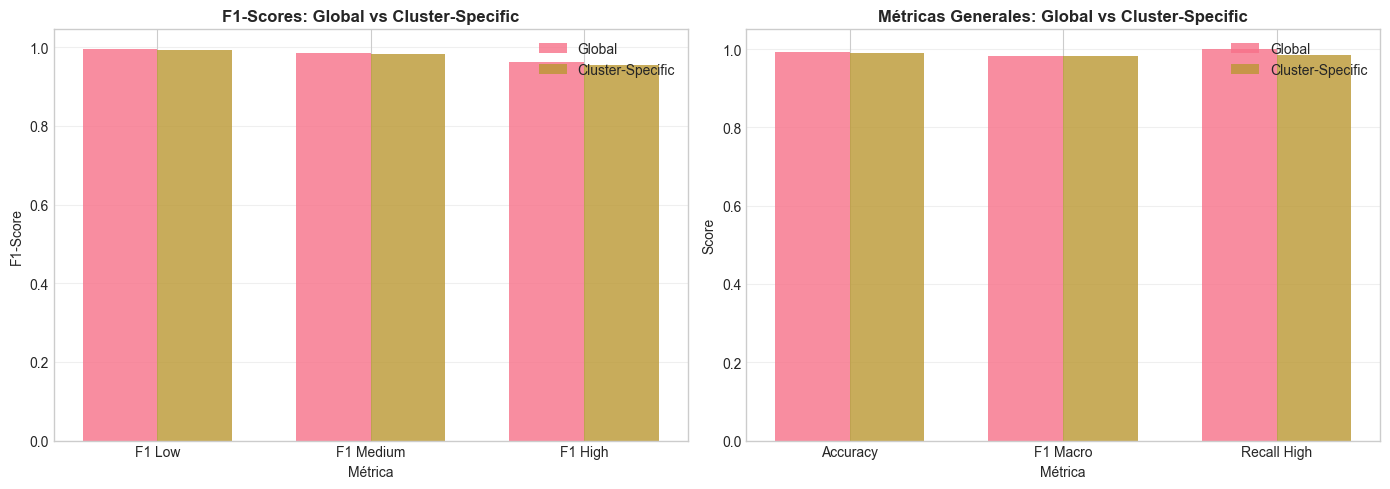

In [9]:
print("\n" + "="*80)
print("📊 COMPARACIÓN: Modelo Global vs Modelos por Cluster")
print("="*80 + "\n")

# Calcular métricas agregadas de modelos por cluster
# (promedio ponderado por tamaño del cluster)
total_test_samples = sum([m['n_test'] for m in cluster_metrics.values()])

weighted_cluster_metrics = {
    'accuracy': sum([m['accuracy'] * m['n_test'] for m in cluster_metrics.values()]) / total_test_samples,
    'f1_macro': sum([m['f1_macro'] * m['n_test'] for m in cluster_metrics.values()]) / total_test_samples,
    'f1_low': sum([m['f1_low'] * m['n_test'] for m in cluster_metrics.values()]) / total_test_samples,
    'f1_medium': sum([m['f1_medium'] * m['n_test'] for m in cluster_metrics.values()]) / total_test_samples,
    'f1_high': sum([m['f1_high'] * m['n_test'] for m in cluster_metrics.values()]) / total_test_samples,
    'recall_high': sum([m['recall_high'] * m['n_test'] for m in cluster_metrics.values()]) / total_test_samples,
    'precision_high': sum([m['precision_high'] * m['n_test'] for m in cluster_metrics.values()]) / total_test_samples
}

# Tabla comparativa
comparison_df = pd.DataFrame({
    'Modelo Global': global_metrics,
    'Modelos por Cluster (avg)': weighted_cluster_metrics
}).T

print("\n📈 Métricas Comparativas:\n")
print(comparison_df.round(4))

# Calcular diferencias
print("\n📊 Diferencias (Cluster - Global):\n")
for metric in comparison_df.columns:
    diff = weighted_cluster_metrics[metric] - global_metrics[metric]
    pct_change = (diff / global_metrics[metric]) * 100 if global_metrics[metric] > 0 else 0
    symbol = '📈' if diff > 0 else '📉' if diff < 0 else '➡️'
    print(f"  {symbol} {metric:20} {diff:+.4f} ({pct_change:+.2f}%)")

# Visualizar comparación
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: F1 Scores por clase
metrics_to_plot = ['f1_low', 'f1_medium', 'f1_high']
x = np.arange(len(metrics_to_plot))
width = 0.35

global_vals = [global_metrics[m] for m in metrics_to_plot]
cluster_vals = [weighted_cluster_metrics[m] for m in metrics_to_plot]

axes[0].bar(x - width/2, global_vals, width, label='Global', alpha=0.8)
axes[0].bar(x + width/2, cluster_vals, width, label='Cluster-Specific', alpha=0.8)
axes[0].set_xlabel('Métrica')
axes[0].set_ylabel('F1-Score')
axes[0].set_title('F1-Scores: Global vs Cluster-Specific', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['F1 Low', 'F1 Medium', 'F1 High'])
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Accuracy y F1 Macro
metrics2 = ['accuracy', 'f1_macro', 'recall_high']
x2 = np.arange(len(metrics2))

global_vals2 = [global_metrics[m] for m in metrics2]
cluster_vals2 = [weighted_cluster_metrics[m] for m in metrics2]

axes[1].bar(x2 - width/2, global_vals2, width, label='Global', alpha=0.8)
axes[1].bar(x2 + width/2, cluster_vals2, width, label='Cluster-Specific', alpha=0.8)
axes[1].set_xlabel('Métrica')
axes[1].set_ylabel('Score')
axes[1].set_title('Métricas Generales: Global vs Cluster-Specific', fontweight='bold')
axes[1].set_xticks(x2)
axes[1].set_xticklabels(['Accuracy', 'F1 Macro', 'Recall High'])
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../docs/figures/comparison_global_vs_cluster.png', dpi=300, bbox_inches='tight')
plt.show()

## 9️⃣ Métricas Detalladas por Cluster


📊 Métricas Detalladas por Cluster:

   accuracy  f1_macro  f1_low  f1_medium  f1_high  recall_high  \
0    0.9167    0.9009  0.9565     0.8889   0.8571          1.0   
1    0.9933    0.9859  0.9960     0.9861   0.9756          1.0   
2    0.9565    0.9464  0.9697     0.9231   0.0000          0.0   

   precision_high  n_train  n_test  
0          0.7500    244.0    48.0  
1          0.9524   5277.0  1335.0  
2          0.0000    100.0    23.0  


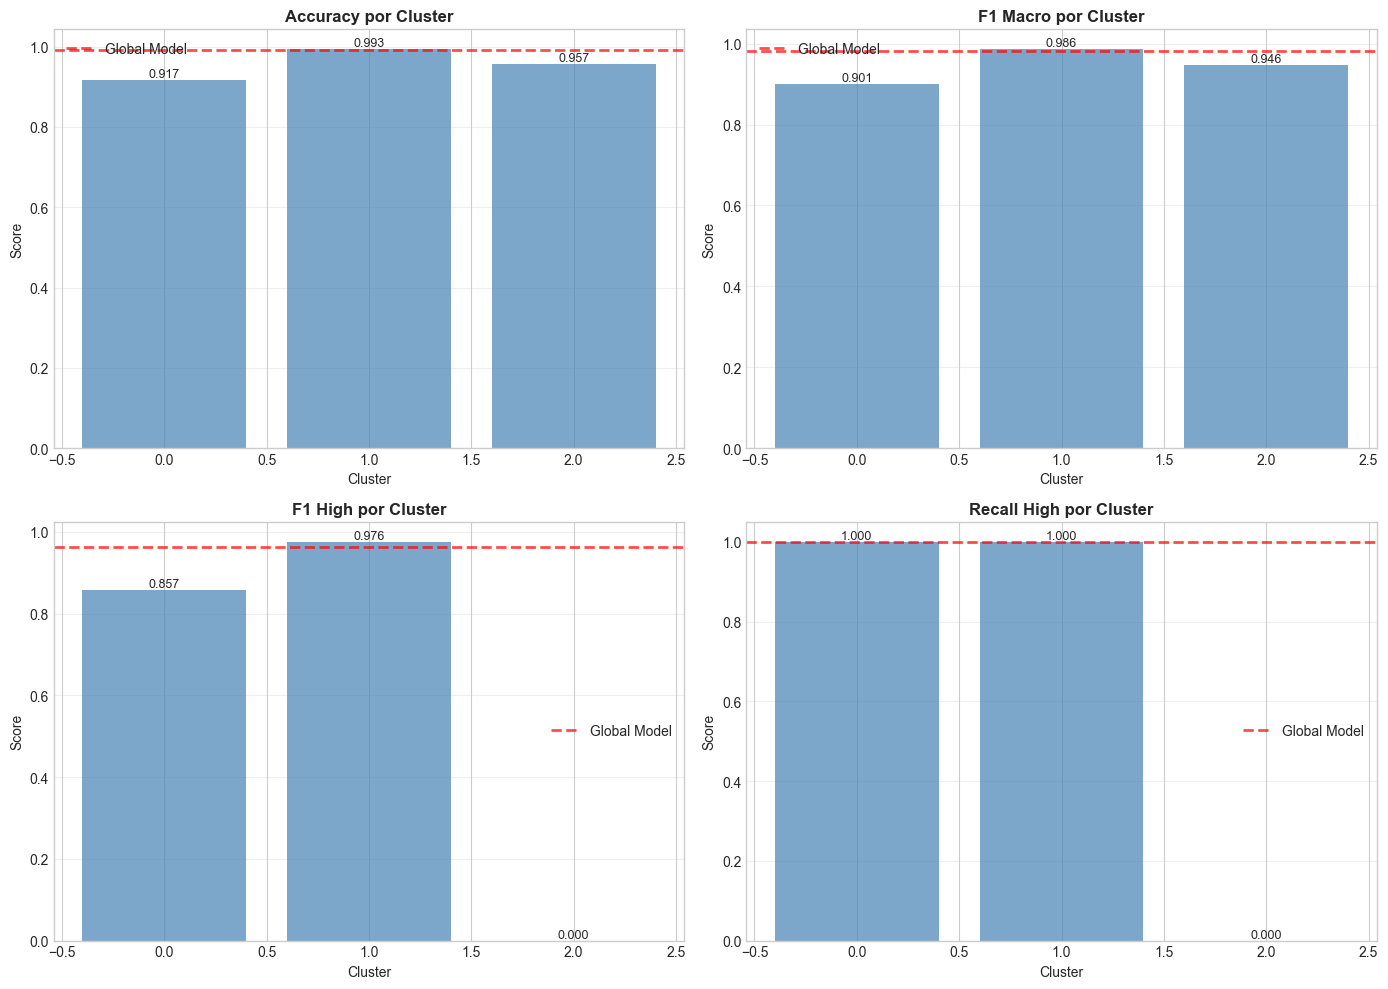

In [10]:
# Crear tabla detallada
cluster_details = pd.DataFrame(cluster_metrics).T
print("\n📊 Métricas Detalladas por Cluster:\n")
print(cluster_details.round(4))

# Visualizar métricas por cluster
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_viz = ['accuracy', 'f1_macro', 'f1_high', 'recall_high']
titles = ['Accuracy por Cluster', 'F1 Macro por Cluster', 
          'F1 High por Cluster', 'Recall High por Cluster']

for idx, (metric, title) in enumerate(zip(metrics_viz, titles)):
    ax = axes[idx // 2, idx % 2]
    cluster_ids = list(cluster_details.index)
    values = cluster_details[metric].values
    
    bars = ax.bar(cluster_ids, values, alpha=0.7, color='steelblue')
    ax.axhline(y=global_metrics[metric], color='red', linestyle='--', 
               linewidth=2, label='Global Model', alpha=0.7)
    
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Score')
    ax.set_title(title, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Anotar valores
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../docs/figures/metrics_by_cluster.png', dpi=300, bbox_inches='tight')
plt.show()

## 🔟 Entrenar KMeans para Inferencia de Cluster

Para la API: necesitamos un modelo KMeans entrenado con las mismas features que usó el clustering original.

In [11]:
print("\n" + "="*80)
print("🎯 ENTRENAR KMEANS PARA INFERENCIA DE CLUSTER")
print("="*80 + "\n")

# Cargar cluster_profiles del notebook 01 V2
try:
    cluster_profiles = pd.read_csv('../data/processed/crohn/cluster_profiles.csv', index_col=0)
    print("✓ Cluster profiles cargados")
    print(cluster_profiles)
except FileNotFoundError:
    print("⚠️  cluster_profiles.csv no encontrado")
    print("   Creando profiles simplificados desde datos actuales...\n")
    
    # Crear profiles desde datos actuales
    symptom_cols = ['abdominal_pain', 'blood_in_stool', 'diarrhea', 'fatigue', 'fever', 'nausea']
    cluster_profiles = df.groupby('cluster')[symptom_cols].mean()
    print(cluster_profiles)

# Features de síntomas para clustering (igual que notebook 01 V2)
symptom_features = ['abdominal_pain', 'blood_in_stool', 'diarrhea', 'fatigue', 'fever', 'nausea']

# Filtrar solo features disponibles
available_features = [f for f in symptom_features if f in df.columns]
print(f"\nFeatures para clustering: {available_features}")

# Preparar datos para KMeans (usar todos los datos con cluster conocido)
X_clustering = df[available_features].copy()
y_clustering = df['cluster'].copy()

# Normalizar (StandardScaler)
scaler = StandardScaler()
X_clustering_scaled = scaler.fit_transform(X_clustering)

print(f"\nDatos para KMeans: {X_clustering_scaled.shape}")

# Entrenar KMeans con k=3
n_clusters = len(df['cluster'].unique())
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=50)

print(f"\nEntrenando KMeans con k={n_clusters}...")
kmeans.fit(X_clustering_scaled)
print("✓ KMeans entrenado")

# Verificar centroides
print(f"\nCentroides (escalados):\n")
centroids_df = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=available_features,
    index=[f'Cluster {i}' for i in range(n_clusters)]
)
print(centroids_df.round(3))

# Guardar scaler y kmeans en directorio Crohn
with open('../models/crohn/cluster_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("\n✓ Scaler guardado: models/crohn/cluster_scaler.pkl")

with open('../models/crohn/cluster_kmeans.pkl', 'wb') as f:
    pickle.dump(kmeans, f)
print("✓ KMeans guardado: models/crohn/cluster_kmeans.pkl")

# Guardar metadata de clustering
cluster_metadata = {
    'ibd_type': 'crohn',
    'n_clusters': n_clusters,
    'features': available_features,
    'trained_date': datetime.now().isoformat(),
    'n_samples': len(X_clustering)
}

with open('../models/crohn/cluster_metadata.json', 'w') as f:
    json.dump(cluster_metadata, f, indent=2)
print("✓ Metadata guardada: models/crohn/cluster_metadata.json")


🎯 ENTRENAR KMEANS PARA INFERENCIA DE CLUSTER

✓ Cluster profiles cargados
         abdominal_pain  blood_in_stool  diarrhea   fatigue     fever  \
cluster                                                                 
0              1.610093        2.127648  1.464079  1.714001  0.000000   
1              1.097630        0.029405  0.685087  1.627738  0.015254   
2              0.863733        0.000000  0.538265  2.154018  2.633681   

           nausea  
cluster            
0        0.561708  
1        0.588597  
2        0.533588  

Features para clustering: ['abdominal_pain', 'blood_in_stool', 'diarrhea', 'fatigue', 'fever', 'nausea']

Datos para KMeans: (7027, 6)

Entrenando KMeans con k=3...
✓ KMeans entrenado

Centroides (escalados):

           abdominal_pain  blood_in_stool  diarrhea  fatigue  fever  nausea
Cluster 0          -0.408          -0.110    -0.328   -0.415 -0.120  -0.362
Cluster 1           0.901           0.244     0.723    0.887 -0.116   0.793
Cluster 2           

## 1️⃣1️⃣ Guardar Modelos por Cluster

In [12]:
print("\n" + "="*80)
print("💾 GUARDANDO MODELOS POR CLUSTER - CROHN")
print("="*80 + "\n")

for cluster_id, model in cluster_models.items():
    model_path = f'../models/crohn/rf_severity_classifier_cluster_{cluster_id}.pkl'
    
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    
    size_mb = Path(model_path).stat().st_size / (1024**2)
    print(f"✓ Cluster {cluster_id}: {model_path} ({size_mb:.2f} MB)")

# Guardar metadata de modelos por cluster
cluster_models_metadata = {
    'ibd_type': 'crohn',
    'trained_date': datetime.now().isoformat(),
    'n_clusters': len(cluster_models),
    'features': feature_cols,
    'target': target_col,
    'model_type': 'RandomForestClassifier',
    'clusters': {}
}

for cluster_id in cluster_models.keys():
    cluster_models_metadata['clusters'][int(cluster_id)] = {
        'model_file': f'rf_severity_classifier_cluster_{cluster_id}.pkl',
        'metrics': {k: float(v) for k, v in cluster_metrics[cluster_id].items() 
                   if k not in ['n_train', 'n_test']},
        'n_train': int(cluster_metrics[cluster_id]['n_train']),
        'n_test': int(cluster_metrics[cluster_id]['n_test'])
    }

with open('../models/crohn/cluster_models_metadata.json', 'w') as f:
    json.dump(cluster_models_metadata, f, indent=2)

print("\n✓ Metadata guardada: models/crohn/cluster_models_metadata.json")


💾 GUARDANDO MODELOS POR CLUSTER - CROHN

✓ Cluster 0: ../models/crohn/rf_severity_classifier_cluster_0.pkl (0.29 MB)
✓ Cluster 1: ../models/crohn/rf_severity_classifier_cluster_1.pkl (1.47 MB)
✓ Cluster 2: ../models/crohn/rf_severity_classifier_cluster_2.pkl (0.12 MB)

✓ Metadata guardada: models/crohn/cluster_models_metadata.json


## 1️⃣2️⃣ Guardar Reporte Completo

In [13]:
# Crear reporte completo
report = {
    'title': 'Cluster-Stratified Model Training Report - CROHN',
    'ibd_type': 'crohn',
    'date': datetime.now().isoformat(),
    'global_model': {
        'metrics': {k: float(v) for k, v in global_metrics.items()},
        'model_file': 'rf_severity_classifier.pkl'
    },
    'cluster_models': {
        'weighted_avg_metrics': {k: float(v) for k, v in weighted_cluster_metrics.items()},
        'individual_clusters': cluster_models_metadata['clusters']
    },
    'comparison': {
        'improvements': {},
        'recommendation': ''
    }
}

# Calcular mejoras
for metric in global_metrics.keys():
    diff = weighted_cluster_metrics[metric] - global_metrics[metric]
    pct_change = (diff / global_metrics[metric]) * 100 if global_metrics[metric] > 0 else 0
    report['comparison']['improvements'][metric] = {
        'absolute_diff': float(diff),
        'percent_change': float(pct_change),
        'improved': bool(diff > 0)
    }

# Recomendación
f1_high_improved = report['comparison']['improvements']['f1_high']['improved']
recall_high_improved = report['comparison']['improvements']['recall_high']['improved']

if f1_high_improved and recall_high_improved:
    report['comparison']['recommendation'] = "USAR MODELOS POR CLUSTER: Mejoran las métricas clave (F1 y Recall de HIGH)"
elif f1_high_improved or recall_high_improved:
    report['comparison']['recommendation'] = "EVALUAR: Mejora parcial en métricas clave. Considerar trade-offs."
else:
    report['comparison']['recommendation'] = "MANTENER MODELO GLOBAL: Los modelos por cluster no mejoran significativamente"

# Guardar reporte
report_path = '../reports/crohn_cluster_stratified_training_report.json'
with open(report_path, 'w') as f:
    json.dump(report, f, indent=2)

print(f"\n✓ Reporte completo guardado: {report_path}")

# Mostrar recomendación
print("\n" + "="*80)
print("💡 RECOMENDACIÓN FINAL - CROHN")
print("="*80)
print(f"\n{report['comparison']['recommendation']}")
print("\n" + "="*80)


✓ Reporte completo guardado: ../reports/crohn_cluster_stratified_training_report.json

💡 RECOMENDACIÓN FINAL - CROHN

MANTENER MODELO GLOBAL: Los modelos por cluster no mejoran significativamente



## ✅ Resumen del Notebook - CROHN

### Lo que hemos logrado:

1. ✅ Entrenado **3 modelos RF** (uno por cluster de fenotipo para CROHN)
2. ✅ Comparado métricas: **Global vs Cluster-Specific**
3. ✅ Guardado modelos por cluster + KMeans + Scaler para inferencia
4. ✅ Generado reporte completo con recomendación

### Archivos generados:

- `models/crohn/rf_severity_classifier_cluster_0.pkl` - Modelo Cluster 0
- `models/crohn/rf_severity_classifier_cluster_1.pkl` - Modelo Cluster 1
- `models/crohn/rf_severity_classifier_cluster_2.pkl` - Modelo Cluster 2
- `models/crohn/cluster_kmeans.pkl` - KMeans para inferir cluster de nuevos usuarios
- `models/crohn/cluster_scaler.pkl` - StandardScaler para normalizar features
- `models/crohn/cluster_models_metadata.json` - Metadata de modelos
- `models/crohn/cluster_metadata.json` - Metadata de clustering
- `reports/crohn_cluster_stratified_training_report.json` - Reporte completo

### Próximos pasos:

1. **Notebook 05**: Entrenar modelos para Colitis Ulcerosa
2. **Actualizar API** (`api/ml_model.py`) - Ya actualizada para soportar Crohn y CU
3. **Probar API** con nuevos endpoints
4. **Evaluar en producción** y monitorear métricas